In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
from sklearn.datasets import load_iris
X, y = load_iris(return_X_y=True)
print(X.shape) # output size of the dataset

(150, 4)


Look at the scatter of points for each pair of attributes, where the color denotes the true class label

In [7]:
def pairplot(X, y, colors):
    fig, axes = plt.subplots(nrows=X.shape[1], ncols=X.shape[1], figsize=(15,15))

    for i in range(X.shape[1]): # use xrange for Python 2
        for j in range(X.shape[1]):
            if i == j:
                #axes[i, j].hist(X[:, i], 15)
                axes[i, j].scatter(X[:, i], X[:, i], c=colors[y])
            else:
                axes[i, j].scatter(X[:, i], X[:, j], c=colors[y])
            if X.shape[1] - 1:
                axes[i, j].set_xlabel(j)
            if j == 0:
                axes[i, j].set_ylabel(i)

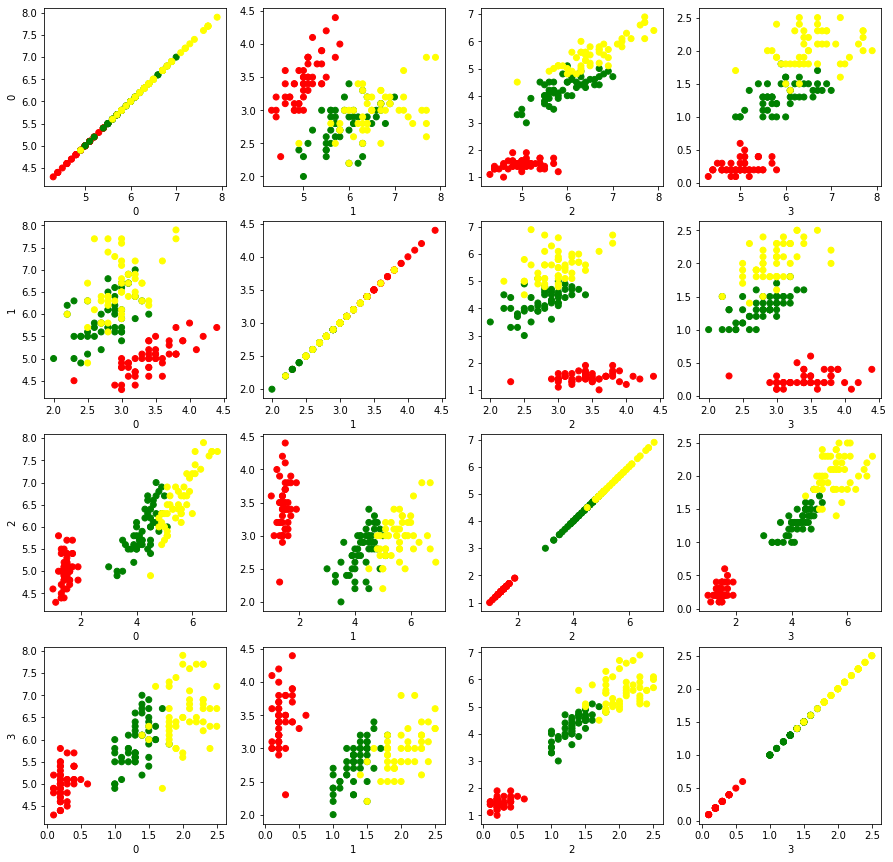

In [8]:
pairplot(X, y, np.array(['red', 'green', 'yellow']))

Further, we will assume that we do not know the exect number of classes and check whether clustering algorithms are can distinguish 3 clusters.

# K-Means

First, we apply K-means for two clusters. Documentation: http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans

In [15]:
from sklearn.cluster import KMeans

kmeans2 = KMeans(n_clusters=2, random_state=10, n_jobs=4, max_iter=1000)
y_pred2 = kmeans2.fit_predict(X)

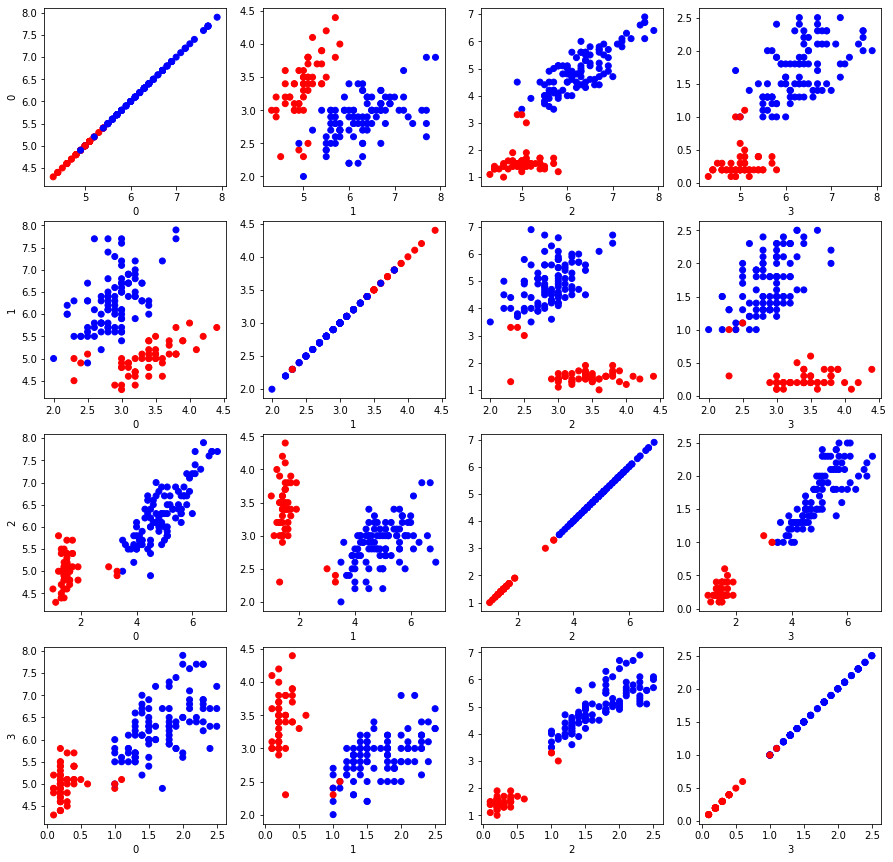

In [14]:
pairplot(X, y_pred2, np.array(['blue', 'red']))

Since usually there are no true class labels when the clustering problem is solved, assessing the quality of clustering is not the most trivial task. In sklearn, there are two suitable measures for this purpose. Lets evaluate them. We will carry out a comparison with true labels for all the clustering methods discussed in this notebook at the end.

In [20]:
from sklearn.metrics import calinski_harabaz_score, silhouette_samples, silhouette_score
import matplotlib.cm as cm # needed to set a color scheme

def estimate_cluster(X, y_pred, name_of_alg=None):
    if not (name_of_alg is None):
        print(("Algorithm: " + name_of_alg))
    
    # Calinski-Harabaz - ratio between the within-cluster dispersion and the between-cluster dispersion
    # Greater is better
    print("Calinski-Harabaz: %.4f" % calinski_harabaz_score(X, y_pred))

    silhouette_avg = silhouette_score(X, y_pred)
    print("Average silhouette: %.4f" % silhouette_avg)

    n_clusters = len(np.unique(y_pred))

    # Show how silhouettes are chaged in each cluster
    fig, ax1 = plt.subplots(figsize=(8,6))
    ax1.set_xlim([-0.1, 1])
    # 10 is needed for indentation
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    sample_silhouette_values = silhouette_samples(X, y_pred)

    y_lower = 10
    # iterate over all the clusters
    for i in range(n_clusters):
        # Aggregate and sort silhouettes of objects in the cluster i
        ith_cluster_silhouette_values = \
            sample_silhouette_values[y_pred == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.get_cmap("nipy_spectral")(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Print the number of the cluster
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute a new lower boundary between cluster silhouettes 
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("Silhouettes of different clusters")
    ax1.set_xlabel("Silhouette value")
    ax1.set_ylabel("Cluster number")

    # Vertical line shows average value of silhouette
    ax1.axvline(x=silhouette_avg, color="red", linestyle="-.")

    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


Algorithm: K-Means, 2 clusters
Calinski-Harabaz: 513.9245
Average silhouette: 0.6810
Sum of squared distances to cluster centroids: 152.3480


/Applications/Anaconda/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)


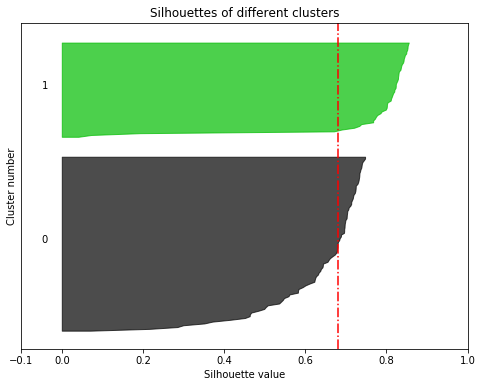

In [21]:
estimate_cluster(X, y_pred2, 'K-Means, 2 clusters')
print("Sum of squared distances to cluster centroids: %.4f" % kmeans2.inertia_)

These silhouettes are pretty goood. But maybe we can get better results. Lets use the elbow method to choose the number of clusters.

In [23]:
J = []
params = np.arange(1, 11)
for k in params:
    kmeans = KMeans(n_clusters=k, random_state=10, n_jobs=4, max_iter=1000)
    kmeans.fit(X)
    J.append(kmeans.inertia_)
J = np.array(J)

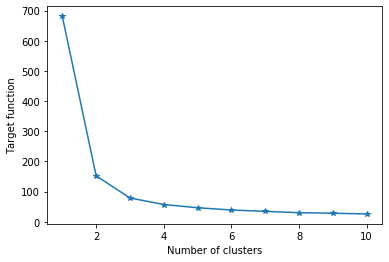

In [24]:
plt.plot(params, J, '-*')
plt.xlabel('Number of clusters')
plt.ylabel('Target function')
plt.show()

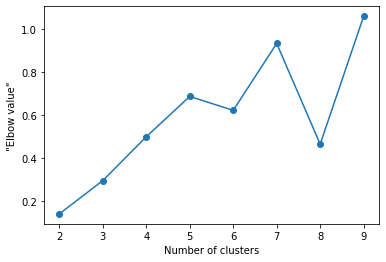

In [25]:
D = np.abs(J[1:-1]-J[2:])/np.abs(J[:-2] - J[1:-1])
plt.plot(params[1:-1], D, '-o')
plt.xlabel('Number of clusters')
plt.ylabel('\"Elbow value\"')
plt.show()

The lowest “elbow value” corresponds to 2 clusters. Knowing the true number of clusters, let's try to train K-Means for three clusters.

Algorithm: K-Means, 3 clusters
Calinski-Harabaz: 561.6278
Average silhouette: 0.5528
Sum of squared distances to cluster centroids: 78.8514


/Applications/Anaconda/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)


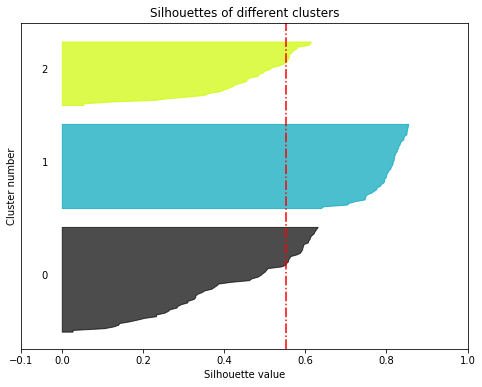

In [26]:
kmeans3 = KMeans(n_clusters=3, random_state=10, n_jobs=4, max_iter=1000)
y_pred3 = kmeans3.fit_predict(X)
estimate_cluster(X, y_pred3, 'K-Means, 3 clusters')
print("Sum of squared distances to cluster centroids: %.4f" % kmeans3.inertia_)

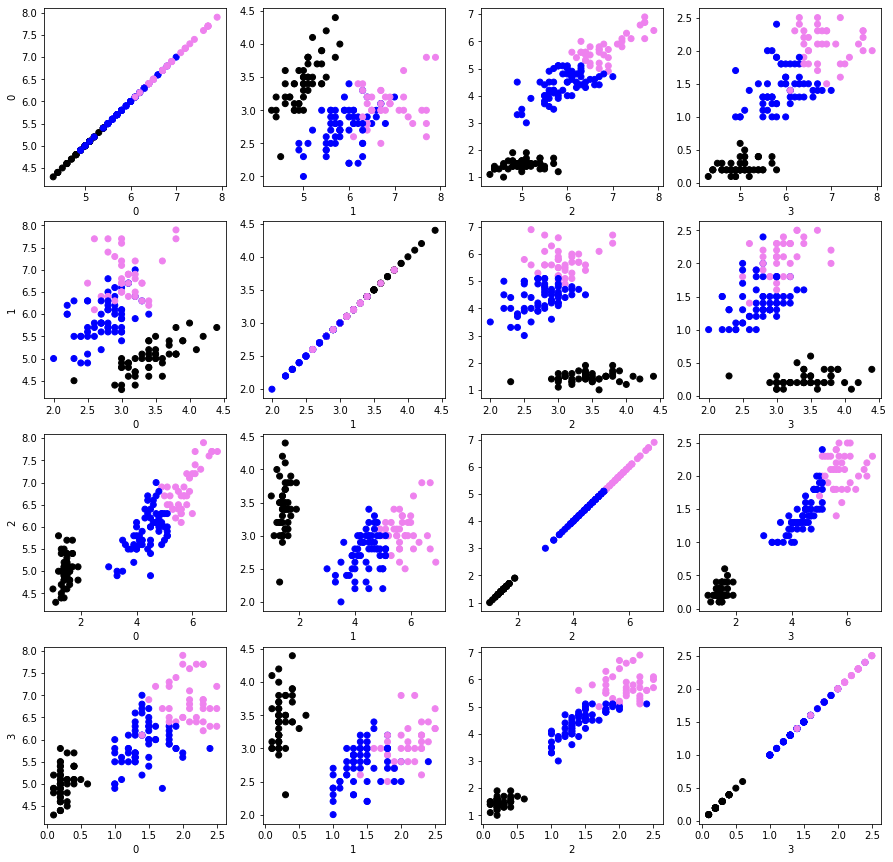

In [27]:
pairplot(X, y_pred3, np.array(['blue', 'black', 'violet']))

In this case 3 clusters are preferable.

# Hierarchical (agglomerative) clustering

In sklearn, hierarchical clustering is represented only by agglomerative clustering. You can choose one of the three criteria for combining two clusters into a larger cluster:
1. 'ward' - minimization of dispersion within the united clusters
2. 'average' - minimization of the average distance between a pair of observations in a cluster
3. 'complete' - maximization of the distance between two observations of different clusters

Lets apply all three criteria in turns.

As you know, to apply hierarchical clustering, a matrix of pairwise distances is needed. If the data is structured, for example, graphs, then you can pass the connectivity matrix as an argument. If we do not use restrictions on the coherence of observations, then it suffices to choose an appropriate affinity measure and pairwise distances will be calculated by the method automatically. In the examples below, we use the Euclidean distance.

As with the K-Means algorithm, you must select the number of clusters.

Documentation: http://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering

### Ward

/Applications/Anaconda/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)
/Applications/Anaconda/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)
/Applications/Anaconda/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)
/Applications/An

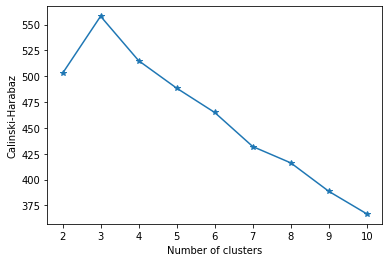

In [29]:
from sklearn.cluster import AgglomerativeClustering

J = []
params = np.arange(2, 11)
for k in params:
    ward_arc = AgglomerativeClustering(n_clusters=k, linkage='ward', affinity='euclidean') 
    # Further we will omit affinity='euclidean', as it is the default value
    ward_arc.fit(X)
    J.append(calinski_harabaz_score(X, ward_arc.labels_))
J = np.array(J)
plt.plot(params, J, '-*')
plt.xlabel('Number of clusters')
plt.ylabel('Calinski-Harabaz')
plt.show()

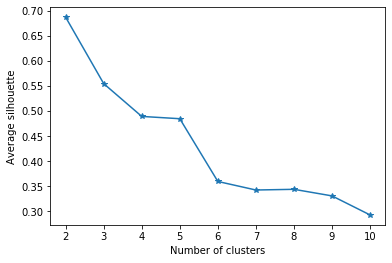

In [30]:
J = []
params = np.arange(2, 11)
for k in params:
    ward_arc = AgglomerativeClustering(n_clusters=k, linkage='ward')
    ward_arc.fit(X)
    J.append(silhouette_score(X, ward_arc.labels_))
J = np.array(J)
plt.plot(params, J, '-*')
plt.xlabel('Number of clusters')
plt.ylabel('Average silhouette')
plt.show()

Algorithm: Ward, 3 clusters
Calinski-Harabaz: 558.0580
Average silhouette: 0.5543


/Applications/Anaconda/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)


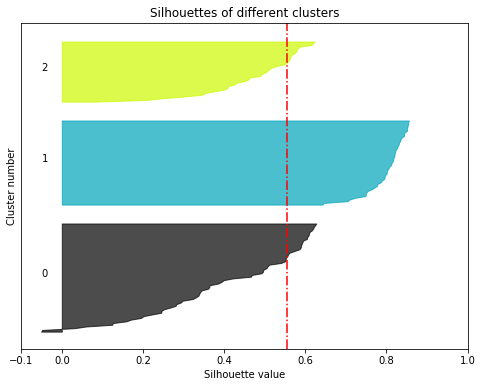

In [32]:
ward_agc = AgglomerativeClustering(n_clusters=3, linkage='ward', compute_full_tree=True)
y_ward3 = ward_agc.fit_predict(X)
estimate_cluster(X, y_ward3, 'Ward, 3 clusters')

The results are comparable to K-Means.

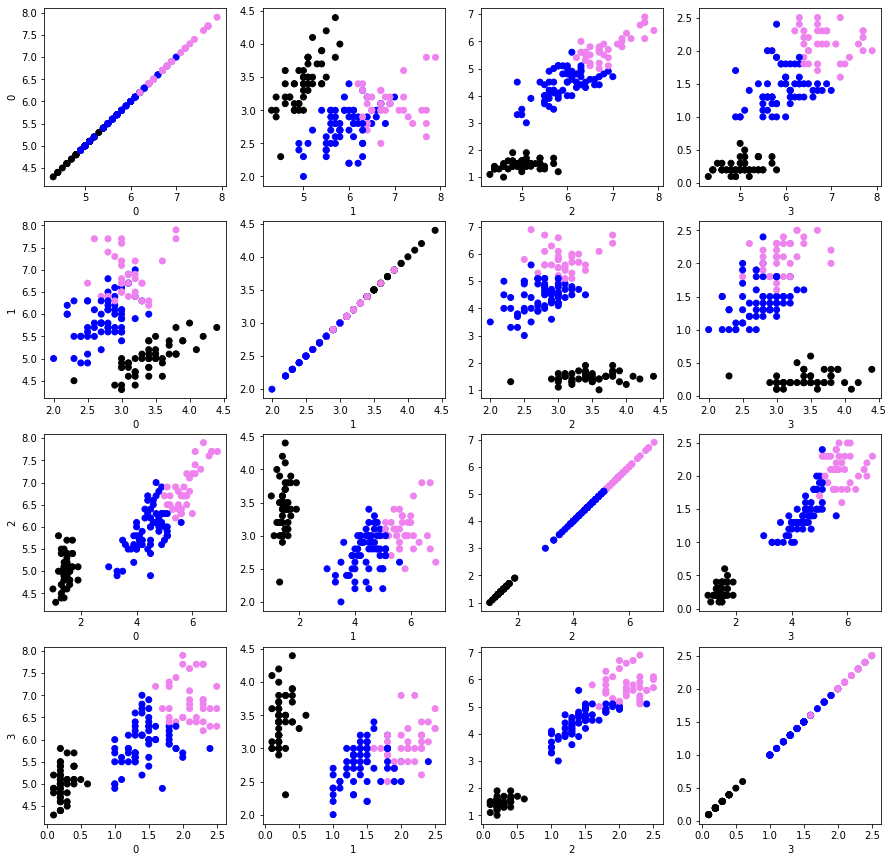

In [33]:
pairplot(X, y_ward3, np.array(['blue', 'black', 'violet']))

### Average

/Applications/Anaconda/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)
/Applications/Anaconda/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)
/Applications/Anaconda/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)
/Applications/An

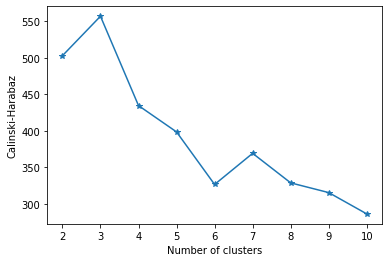

In [34]:
J = []
params = np.arange(2, 11)
for k in params:
    average_arc = AgglomerativeClustering(n_clusters=k, linkage='average')
    average_arc.fit(X)
    J.append(calinski_harabaz_score(X, average_arc.labels_))
J = np.array(J)
plt.plot(params, J, '-*')
plt.xlabel('Number of clusters')
plt.ylabel('Calinski-Harabaz')
plt.show()

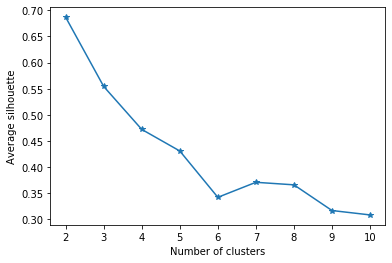

In [35]:
J = []
params = np.arange(2, 11)
for k in params:
    average_arc = AgglomerativeClustering(n_clusters=k, linkage='average')
    average_arc.fit(X)
    J.append(silhouette_score(X, average_arc.labels_))
J = np.array(J)
plt.plot(params, J, '-*')
plt.xlabel('Number of clusters')
plt.ylabel('Average silhouette')
plt.show()

Algorithm: Average, 3 clusters
Calinski-Harabaz: 556.8795
Average silhouette: 0.5542


/Applications/Anaconda/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)


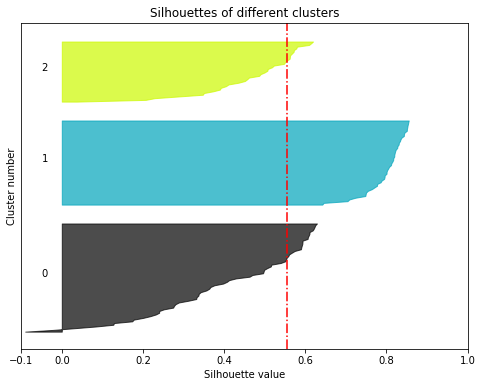

In [36]:
average_agc = AgglomerativeClustering(n_clusters=3, linkage='average', compute_full_tree=True)
y_average3 = average_agc.fit_predict(X)
estimate_cluster(X, y_average3, 'Average, 3 clusters')

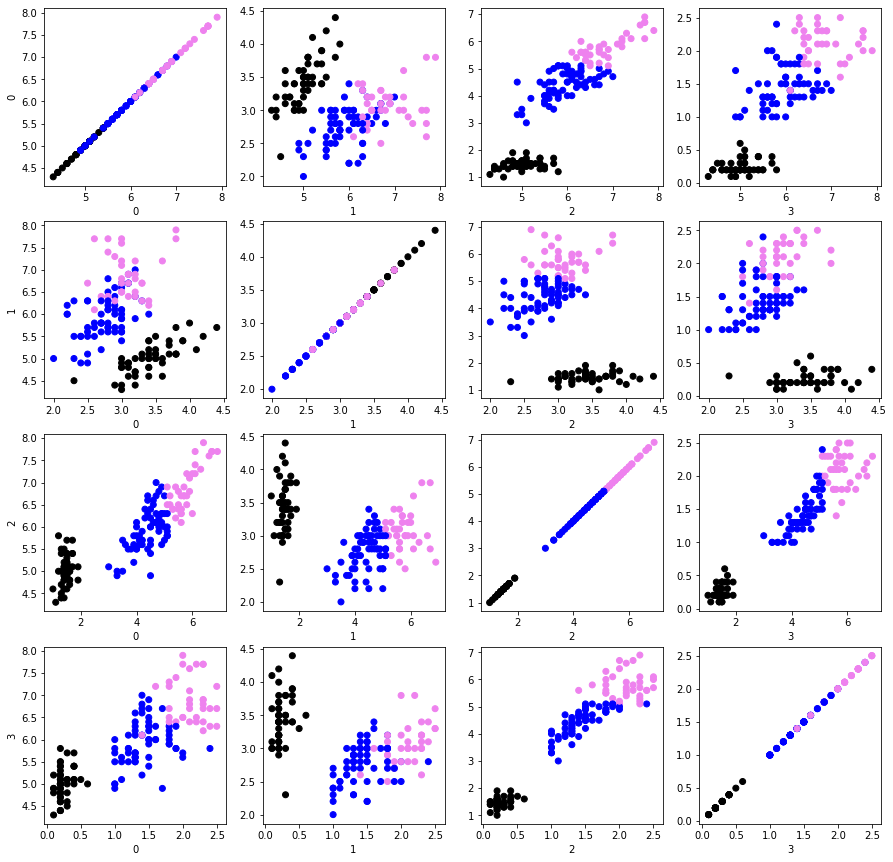

In [37]:
pairplot(X, y_average3, np.array(['blue', 'black', 'violet']))

### Complete

/Applications/Anaconda/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)
/Applications/Anaconda/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)
/Applications/Anaconda/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)
/Applications/An

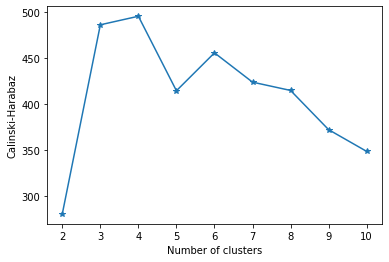

In [38]:
J = []
params = np.arange(2, 11)
for k in params:
    complete_arc = AgglomerativeClustering(n_clusters=k, linkage='complete')
    complete_arc.fit(X)
    J.append(calinski_harabaz_score(X, complete_arc.labels_))
J = np.array(J)
plt.plot(params, J, '-*')
plt.xlabel('Number of clusters')
plt.ylabel('Calinski-Harabaz')
plt.show()

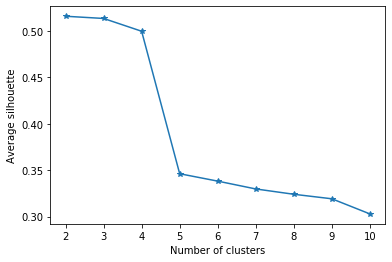

In [39]:
J = []
params = np.arange(2, 11)
for k in params:
    complete_arc = AgglomerativeClustering(n_clusters=k, linkage='complete')
    complete_arc.fit(X)
    J.append(silhouette_score(X, complete_arc.labels_))
J = np.array(J)
plt.plot(params, J, '-*')
plt.xlabel('Number of clusters')
plt.ylabel('Average silhouette')
plt.show()

Algorithm: Complete, 4 clusters
Calinski-Harabaz: 495.1816
Average silhouette: 0.4998


/Applications/Anaconda/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)


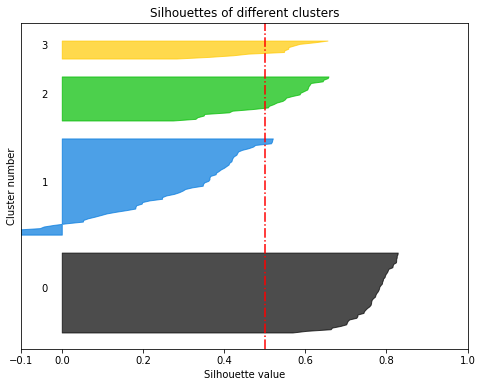

In [40]:
complete_agc = AgglomerativeClustering(n_clusters=4, linkage='complete', compute_full_tree=True)
y_complete4 = complete_agc.fit_predict(X)
estimate_cluster(X, y_complete4, 'Complete, 4 clusters')

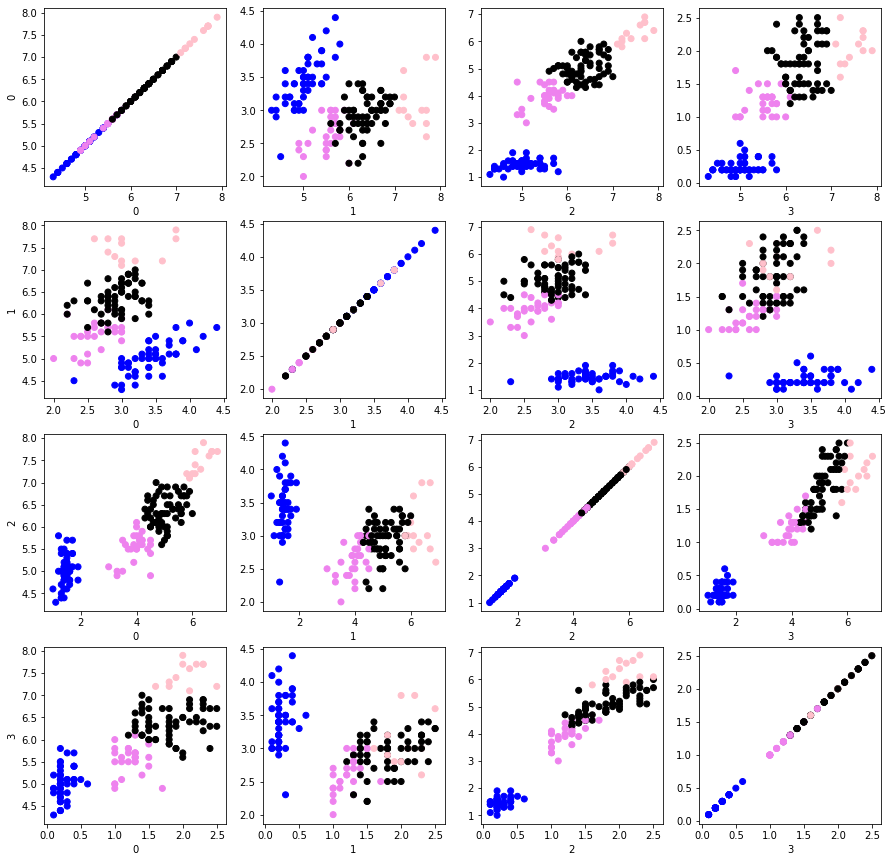

In [41]:
pairplot(X, y_complete4, np.array(['blue', 'black', 'violet', 'pink']))

Algorithm: Complete, 3 clusters
Calinski-Harabaz: 485.9050
Average silhouette: 0.5136


/Applications/Anaconda/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)


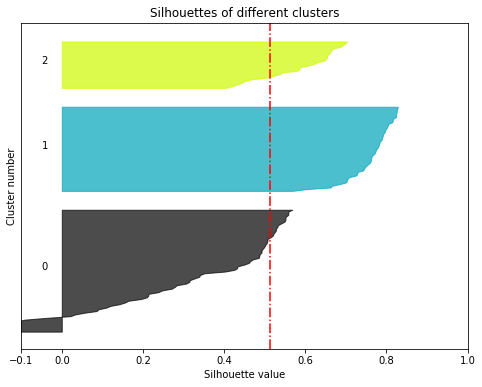

In [42]:
complete_agc = AgglomerativeClustering(n_clusters=3, linkage='complete', compute_full_tree=True)
y_complete3 = complete_agc.fit_predict(X)
estimate_cluster(X, y_complete3, 'Complete, 3 clusters')

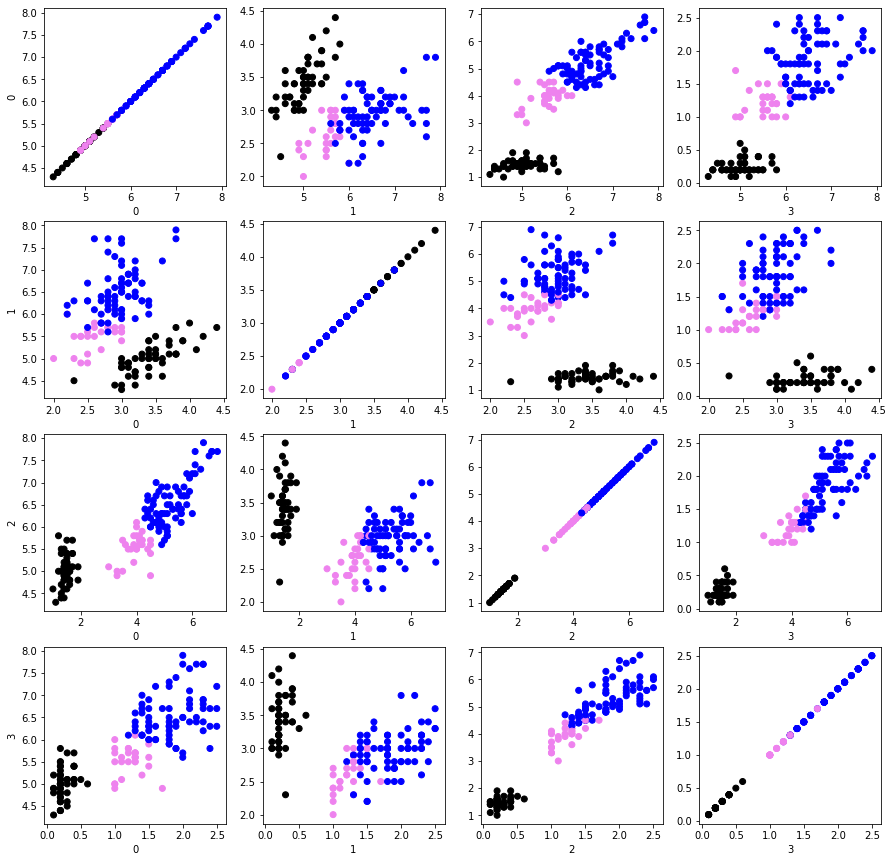

In [43]:
pairplot(X, y_complete3, np.array(['blue', 'black', 'violet']))

### Hierarchical clustering in SciPy

Unfortunately, sklearn has the opportunity to look at the procedure for combining smaller clusters into larger ones, but without taking into account the distance between them. But this feature is presented in the SciPy package. Sklearn also lacks the ability to evaluate cofenetic corelation. Below is an example of how to do this for the 'ward' criterion and Euclidean distance in SciPy.

Documentation: https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html#module-scipy.cluster.hierarchy

Tutorial: https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/

In [45]:
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist

Z = linkage(X, method='ward', metric='euclidean')

c, coph_dists = cophenet(Z, pdist(X))
c

0.8728283153305715

In [47]:
Z.shape

(149, 4)

Every row of Z is formatted as [idx1, idx2, dist, sample_count].

In [48]:
Z[0]

array([101., 142.,   0.,   2.])

On the first step, the algorithm decided to combine the clusters with numbers 9 and 34 (objects), since the distance between them is 0, resulting in a cluster containing 2 objects.

In [49]:
Z[130]

array([253.        , 258.        ,   1.25399362,  12.        ])

In [80]:
np.set_printoptions(precision=5, suppress=True)
Z[:20]

array([[  9.     ,  34.     ,   0.     ,   2.     ],
       [ 37.     , 150.     ,   0.     ,   3.     ],
       [101.     , 142.     ,   0.     ,   2.     ],
       [  7.     ,  39.     ,   0.1    ,   2.     ],
       [  0.     ,  17.     ,   0.1    ,   2.     ],
       [128.     , 132.     ,   0.1    ,   2.     ],
       [ 10.     ,  48.     ,   0.1    ,   2.     ],
       [ 19.     ,  21.     ,   0.14142,   2.     ],
       [ 29.     ,  30.     ,   0.14142,   2.     ],
       [ 57.     ,  93.     ,   0.14142,   2.     ],
       [ 80.     ,  81.     ,   0.14142,   2.     ],
       [116.     , 137.     ,   0.14142,   2.     ],
       [  8.     ,  38.     ,   0.14142,   2.     ],
       [  3.     ,  47.     ,   0.14142,   2.     ],
       [ 27.     ,  28.     ,   0.14142,   2.     ],
       [ 82.     ,  92.     ,   0.14142,   2.     ],
       [ 95.     ,  96.     ,   0.14142,   2.     ],
       [127.     , 138.     ,   0.14142,   2.     ],
       [  1.     ,  45.     ,   0.14142,   2. 

Note that in the second step, the combination of two objects did not occur. The cluster created in the first step and a new object were linked instead. (the objects have numbers from 0 to 149, since there are 150 objects in the data, so 150 is the index of the cluster). Let's look at the values of the attributes of the objects that were combined into the cluster in the second step.

In [50]:
X[[9, 34, 37]]

array([[4.9, 3.1, 1.5, 0.1],
       [4.9, 3.1, 1.5, 0.2],
       [4.9, 3.6, 1.4, 0.1]])

Draw a dendrogram.

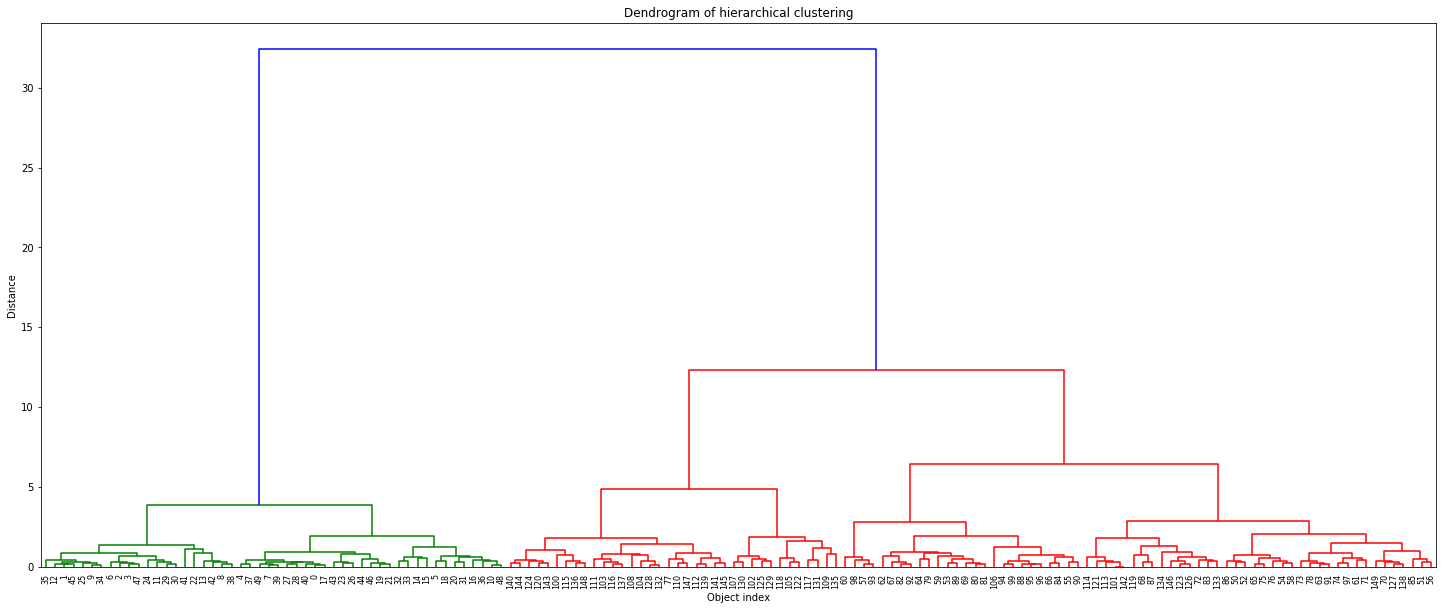

In [51]:
plt.figure(figsize=(25, 10))
plt.title('Dendrogram of hierarchical clustering')
plt.xlabel('Object index')
plt.ylabel('Distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotate labels 90 degrees
    leaf_font_size=8.,  # leaf label font size
)
plt.show()

It turned out to be bulky, but can be reduced by eliminating small clusters.

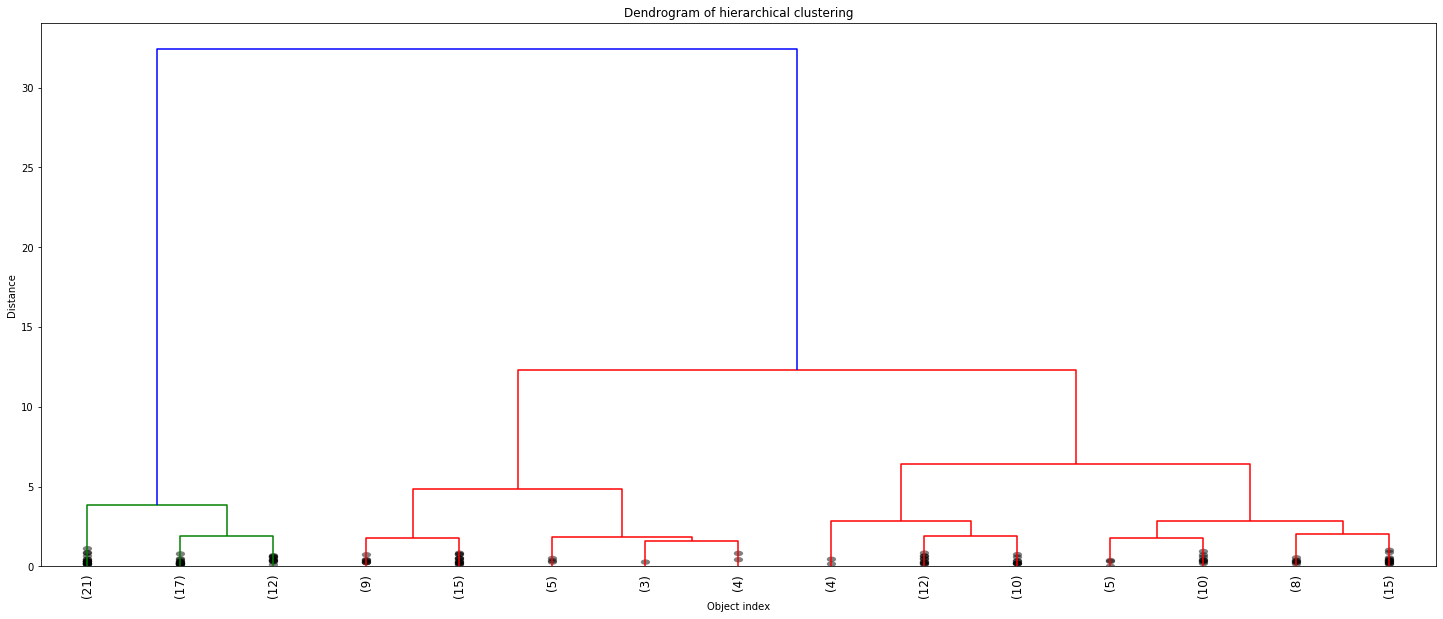

In [52]:
plt.figure(figsize=(25, 10))
plt.title('Dendrogram of hierarchical clustering')
plt.xlabel('Object index')
plt.ylabel('Distance')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only latest p clusters
    p=15,  # number of clusters to show
    show_leaf_counts=True,  # show number of objects in leaf nodes
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # show contracted branches
)
plt.show()

If you need to see the values of the target indicator in clusters and choose a threshold value to determine the number of clusters, you can use the function below (original: https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/).

In [53]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

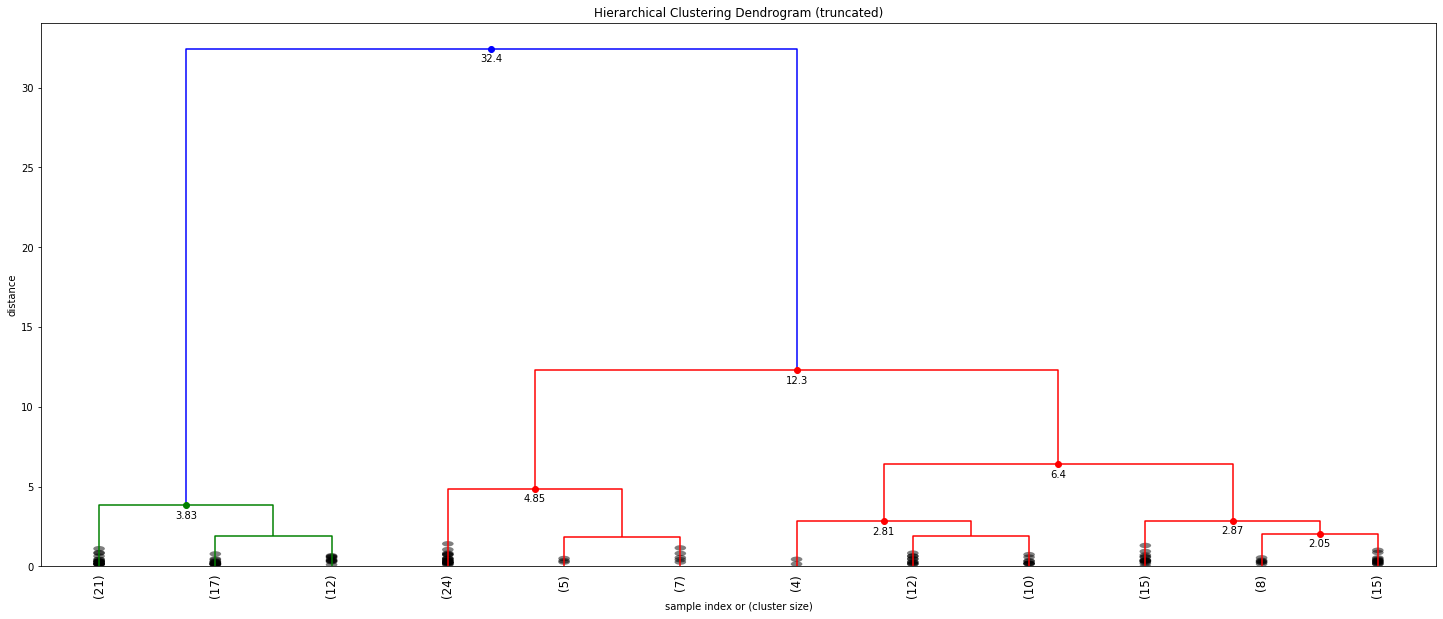

In [54]:
plt.figure(figsize=(25, 10))
fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=2,  # lower threshold for the value of an annotated node
)
plt.show()

Let us see how the clustering result depends on the choice of the threshold value.

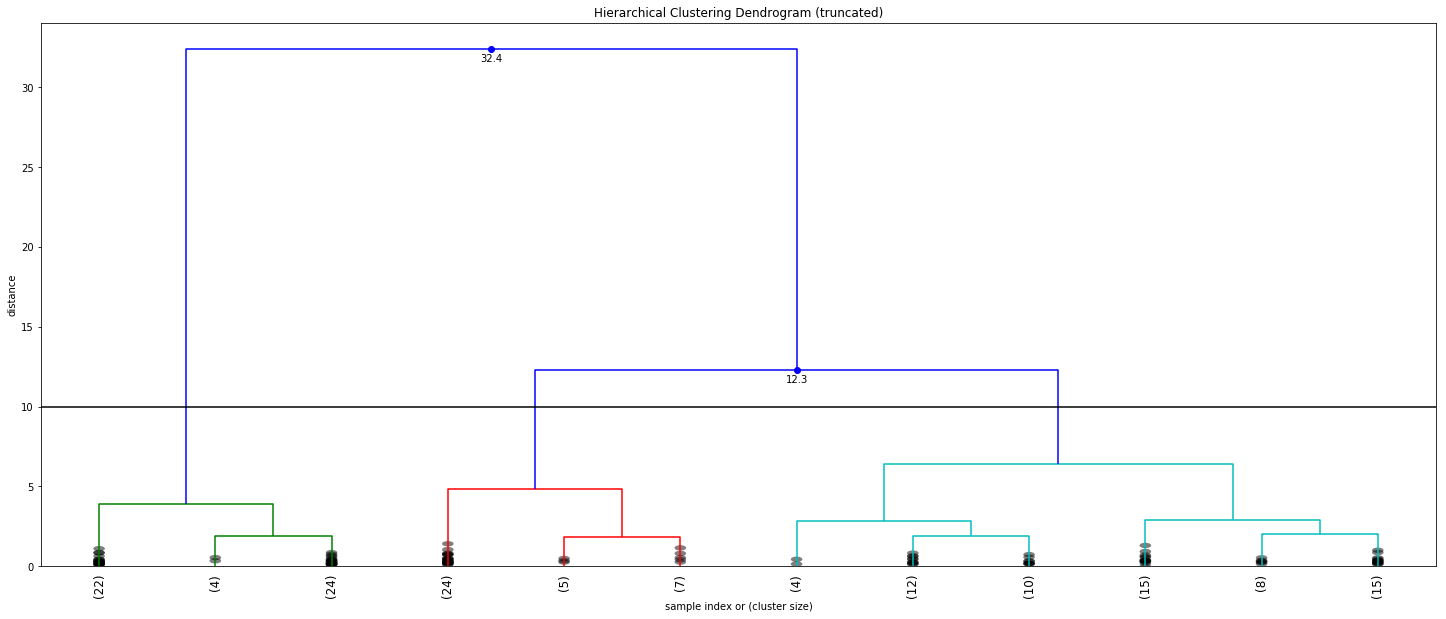

In [86]:
max_d = 10
plt.figure(figsize=(25, 10))
fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d=max_d,
)
plt.show()

# DBSCAN

Documentation: http://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html#sklearn.cluster.DBSCAN

The visualization code is a modified from: http://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html

Estimate number of clusters: 2
Average silhouette: 0.486


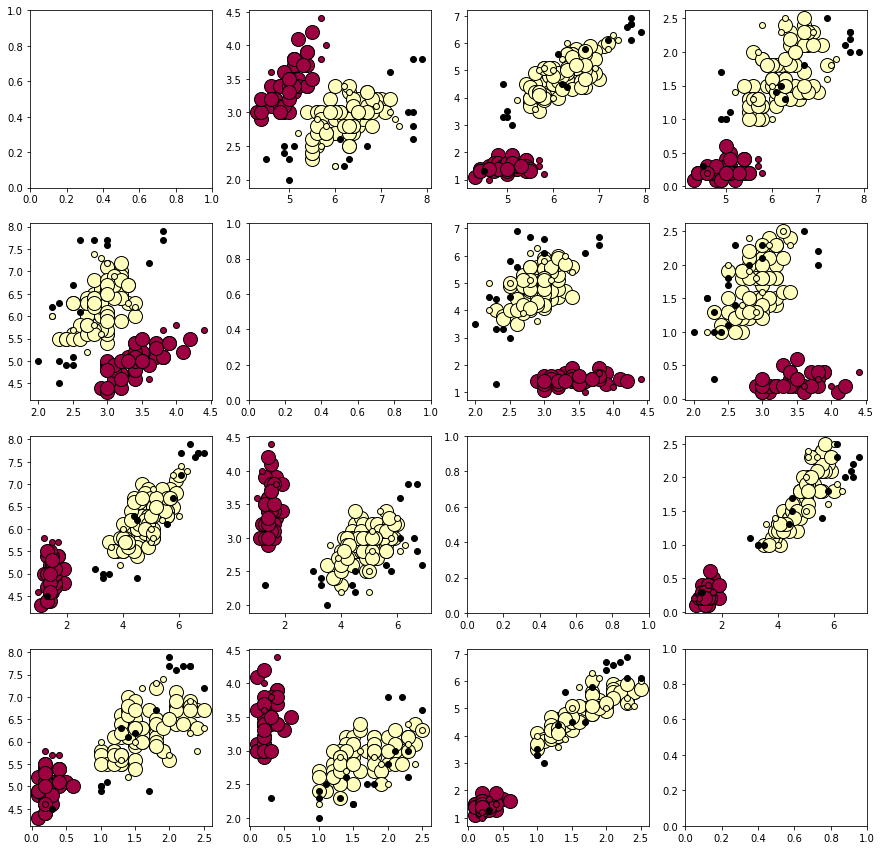

In [56]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.5, min_samples=5, metric='euclidean').fit(X) # with min_samples=5 - 2 clusters
                                                                
core_samples_mask = np.zeros_like(db.labels_, dtype=bool) # create an empty array with the same size as cluster label array
core_samples_mask[db.core_sample_indices_] = True # array of indicators of clusters' "inner points"
labels = db.labels_

# Counting the number of clusters excluding noise.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimate number of clusters: %d' % n_clusters_)
print("Average silhouette: %0.3f" % silhouette_score(X, labels))


unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))] # Exclude black from the color scheme.

fig, axes = plt.subplots(nrows=X.shape[1], ncols=X.shape[1], figsize=(15,15))

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Use black for outliers
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)
    xy_core = X[class_member_mask & core_samples_mask]
    xy_not_core = X[class_member_mask & ~core_samples_mask]

    for i in range(X.shape[1]): # use xrange for Python 2
        for j in range(X.shape[1]):
            if i != j:
                axes[i, j].plot(xy_core[:, i], xy_core[:, j], 'o', markerfacecolor=tuple(col), 
                         markeredgecolor='k', markersize=14)
                axes[i, j].plot(xy_not_core[:, i], xy_not_core[:, j], 'o', markerfacecolor=tuple(col), 
                         markeredgecolor='k', markersize=6)

To understand how the number of allocated clusters changes depending on the eps and min_samples parameters, we can estimate the number of clusters on the value grid.

In [58]:
eps_values = np.arange(0.4, 3, 0.1)
min_sample_values = np.arange(5, 30)
n_cluster_estimates = np.zeros((len(eps_values), len(min_sample_values)))
silhouette = np.zeros(((len(eps_values)), len(min_sample_values)))

for i, eps in enumerate(eps_values):
    for j, min_sample in enumerate(min_sample_values):
        db = DBSCAN(eps=eps, min_samples=min_sample, metric='euclidean').fit(X)
        n_cluster_estimates[i, j]  = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
        if n_cluster_estimates[i, j] > 1:
            silhouette[i,j] = silhouette_score(X, db.labels_)
        else:
            silhouette[i,j] = 0

In [60]:
eps_values = np.arange(0.4, 3, 0.1)
min_sample_values = np.arange(5, 30)
n_cluster_estimates = np.zeros((len(eps_values), len(min_sample_values)))

for i, eps in enumerate(eps_values):
    for j, min_sample in enumerate(min_sample_values):
        db = DBSCAN(eps=eps, min_samples=min_sample, metric='euclidean').fit(X)
        n_cluster_estimates[i, j]  = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)

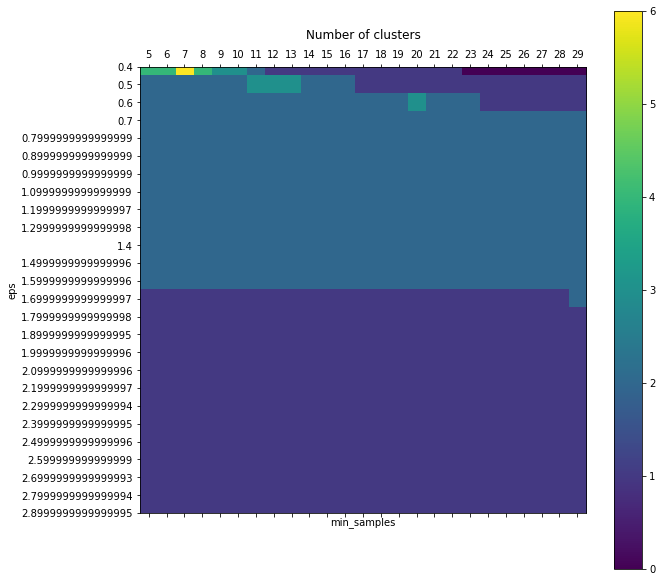

In [63]:
plt.figure(figsize=(10,10))        
plt.matshow(n_cluster_estimates, fignum=1)
plt.colorbar()
plt.xlabel('min_samples')
plt.ylabel('eps')
plt.title('Number of clusters')
plt.xticks(np.arange(len(min_sample_values)), min_sample_values)
plt.yticks(np.arange(len(eps_values)), eps_values)
plt.show()

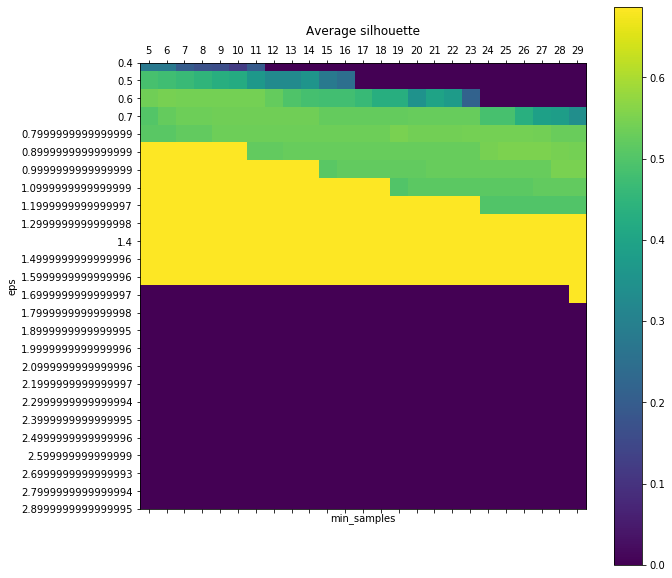

In [64]:
plt.figure(figsize=(10,10))        
plt.matshow(silhouette, fignum=1)
plt.colorbar()
plt.xlabel('min_samples')
plt.ylabel('eps')
plt.title('Average silhouette')
plt.xticks(np.arange(len(min_sample_values)), min_sample_values)
plt.yticks(np.arange(len(eps_values)), eps_values)
plt.show()

The maximum silhouette value is achieved for two clusters. For example, with eps = 1.1 and min_samples = 10.

Estimate number of clusters: 2
Average silhouette: 0.687


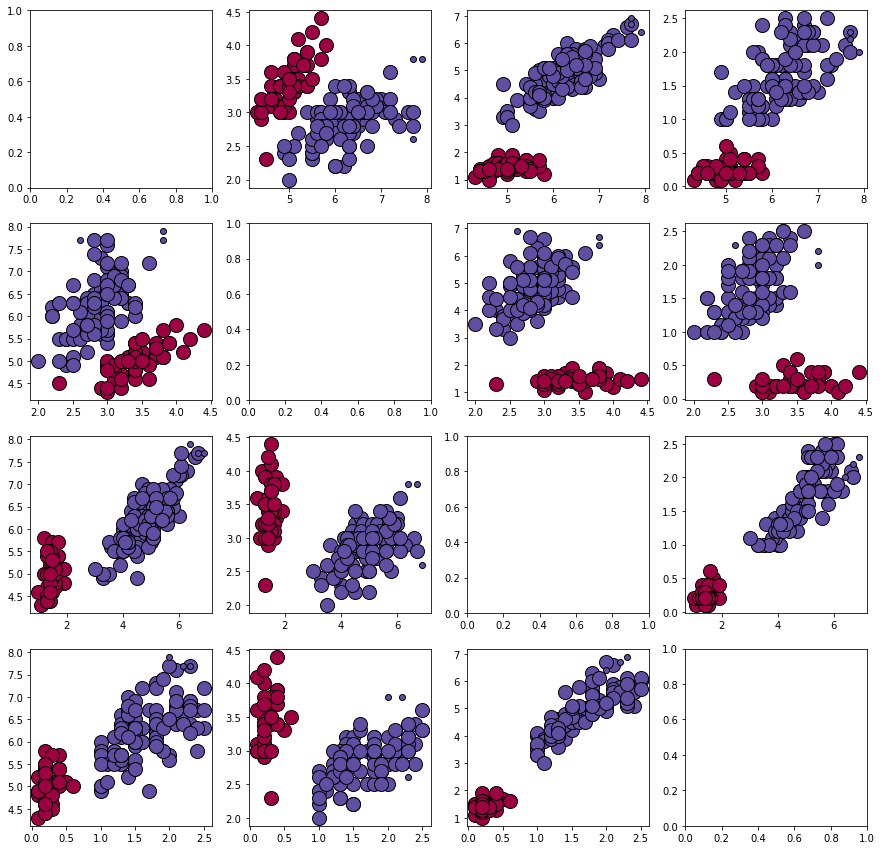

In [65]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=1.1, min_samples=10, metric='euclidean').fit(X)
                                                                
core_samples_mask = np.zeros_like(db.labels_, dtype=bool) # create an empty array with the same size as cluster label array
core_samples_mask[db.core_sample_indices_] = True # array of indicators of clusters' "inner points"
labels = db.labels_

# Counting the number of clusters excluding noise.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimate number of clusters: %d' % n_clusters_)
print("Average silhouette: %0.3f" % silhouette_score(X, labels))


unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))] # Exclude black from the color scheme.

fig, axes = plt.subplots(nrows=X.shape[1], ncols=X.shape[1], figsize=(15,15))

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Use black for outliers
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)
    xy_core = X[class_member_mask & core_samples_mask]
    xy_not_core = X[class_member_mask & ~core_samples_mask]

    for i in range(X.shape[1]): # use xrange for Python 2
        for j in range(X.shape[1]):
            if i != j:
                axes[i, j].plot(xy_core[:, i], xy_core[:, j], 'o', markerfacecolor=tuple(col), 
                         markeredgecolor='k', markersize=14)
                axes[i, j].plot(xy_not_core[:, i], xy_not_core[:, j], 'o', markerfacecolor=tuple(col), 
                         markeredgecolor='k', markersize=6)

# Spectral clustering

Since spectral clustering is clustering on graphs, it is necessary to construct a similarity graph for existing objects. In sklearn, you don’t have to do this yourself, but just choose a way to define it (affinity). The easiest way is to connect only the objects closest in Euclidean measure.

In [93]:
from sklearn.cluster import SpectralClustering

spectral = SpectralClustering(n_clusters=3, affinity='nearest_neighbors', n_neighbors=10, n_jobs=4).fit(X)
y_spectral_nn3 = spectral.labels_

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\manifold\spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


Algorithm: Spectral clustering (nn), 3 clusters
Calinski-Harabaz: 555.6662
Average silhouette: 0.5539


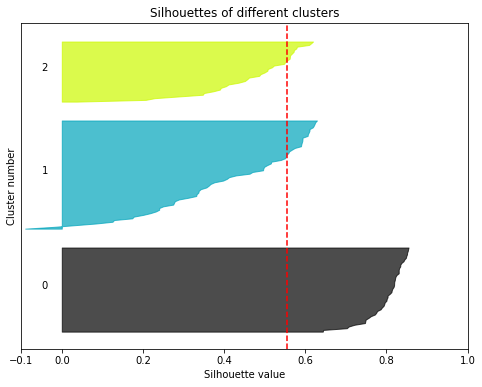

In [94]:
estimate_cluster(X, y_spectral_nn3, 'Spectral clustering (nn), 3 clusters')

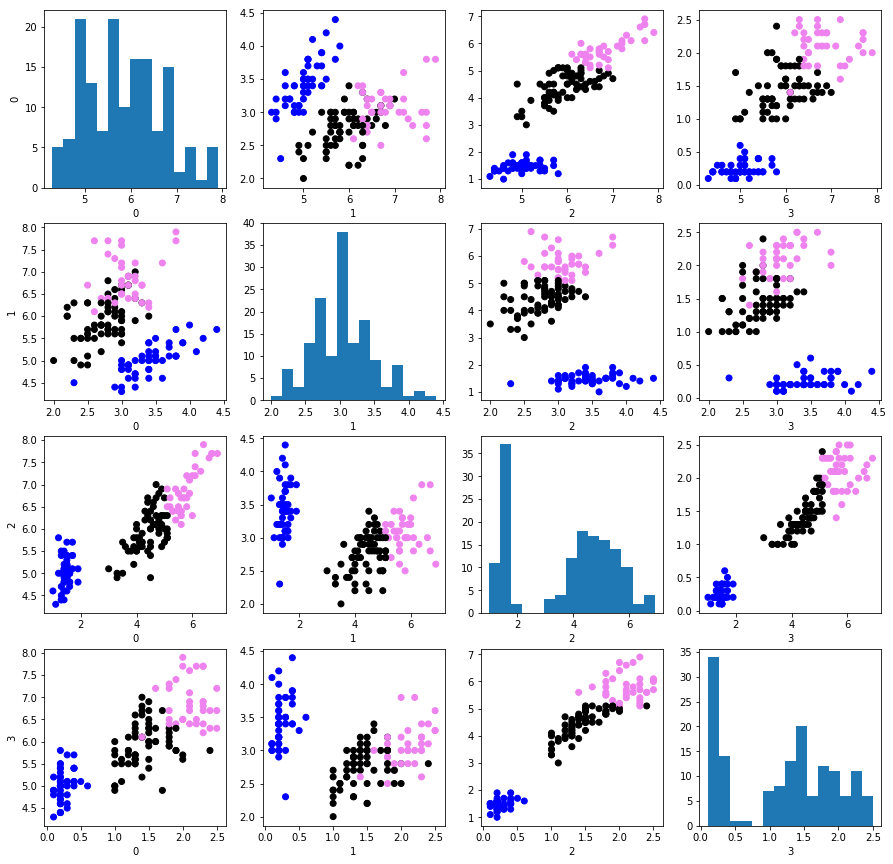

In [95]:
pairplot(X, y_spectral_nn3, np.array(['blue', 'black', 'violet']))

Another example: use the Gaussian core to determine the similarity.

Algorithm: Spectral clustering (rbf), 3 clusters
Calinski-Harabaz: 558.9162
Average silhouette: 0.5509


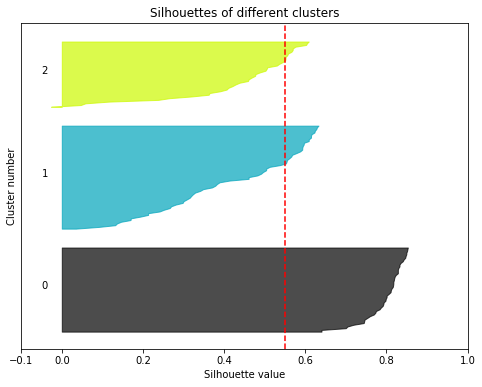

In [96]:
spectral = SpectralClustering(n_clusters=3, affinity='rbf', n_jobs=4).fit(X)
y_spectral_rbf3 = spectral.labels_
estimate_cluster(X, y_spectral_rbf3, 'Spectral clustering (rbf), 3 clusters')

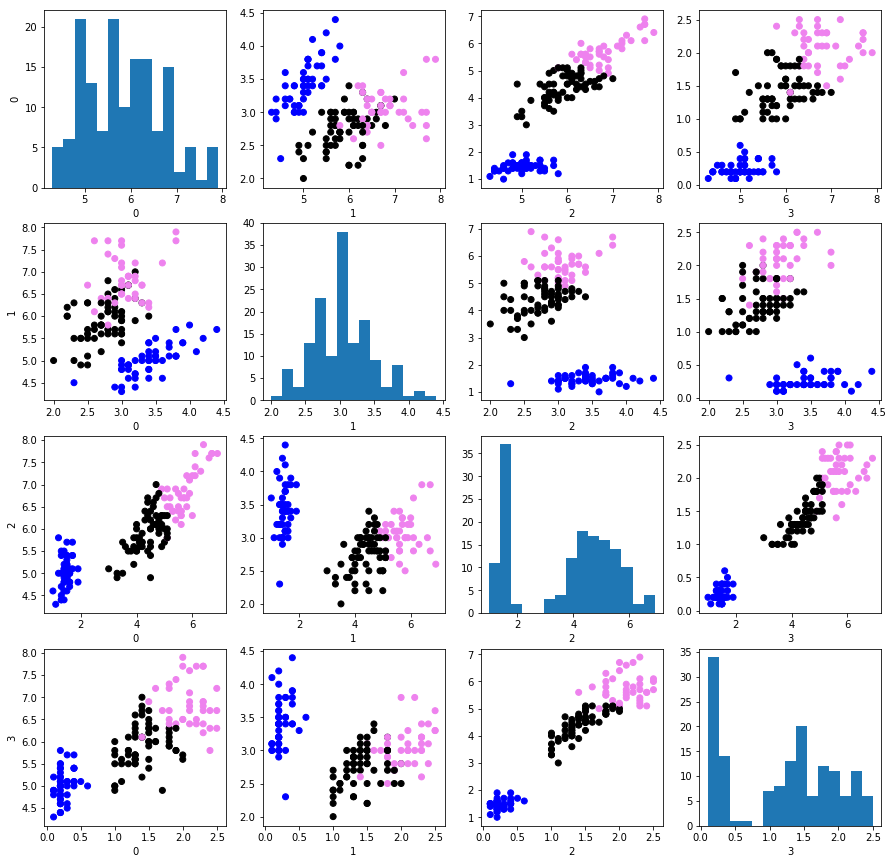

In [97]:
pairplot(X, y_spectral_rbf3, np.array(['blue', 'black', 'violet']))